In [11]:
# python demo.py --config-file configs/diffdet.coco.swinbase.yaml --input inference/images/sport.jpg --opts MODEL.WEIGHTS diffdet_coco_swinbase.pth

In [12]:
import argparse
import glob
import multiprocessing as mp
import os
import tempfile
import time
import warnings
from dataclasses import dataclass, field

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from matplotlib import pyplot as plt
from PIL import Image

from diffusiondet import add_diffusiondet_config
from diffusiondet.predictor import VisualizationDemo
from diffusiondet.util.model_ema import add_model_ema_configs


In [13]:
@dataclass
class Arguments:
    config_file: str = "configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml" # path to config file
    webcam: bool = False # Take inputs from webcam.
    video_input: bool = False # Path to video file.
    input = [] # A list of space separated input images or a single glob pattern such as 'directory/*.jpg'
    output: str = None # A file or directory to save output visualizations. If not given, will show output in an OpenCV window.
    confidence_threshold: float = 0.5 # Minimum score for instance predictions to be shown
    opts = [] # Modify config options using the command-line 'KEY VALUE' pairs
    

In [14]:
args = Arguments()
args.config_file = "configs/diffdet.coco.swinbase.yaml"
args.opts = ['MODEL.WEIGHTS', 'weights/diffdet_coco_swinbase.pth'] # put weights in weights directory
args.output = "runs/output"
args.confidence_threshold = 0.3

#### for single image inference

In [15]:
args.input = ["inference/images/bus.jpg"]

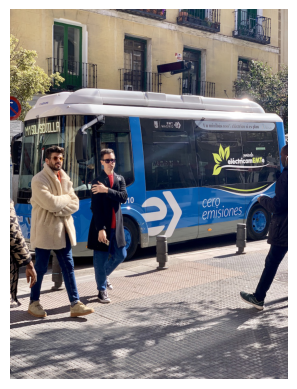

In [16]:
img = read_image(args.input[0], format="BGR")
rgb_img = img[:,:,::-1]
plt.axis('off')
plt.imshow(rgb_img)

In [17]:
def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    # To use demo for Panoptic-DeepLab, please uncomment the following two lines.
    # from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config  # noqa
    # add_panoptic_deeplab_config(cfg)
    add_diffusiondet_config(cfg)
    add_model_ema_configs(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = args.confidence_threshold
    cfg.freeze()
    return cfg

In [18]:
cfg = setup_cfg(args)

In [19]:
predictions, visualized_output = VisualizationDemo(cfg).run_on_image(img)

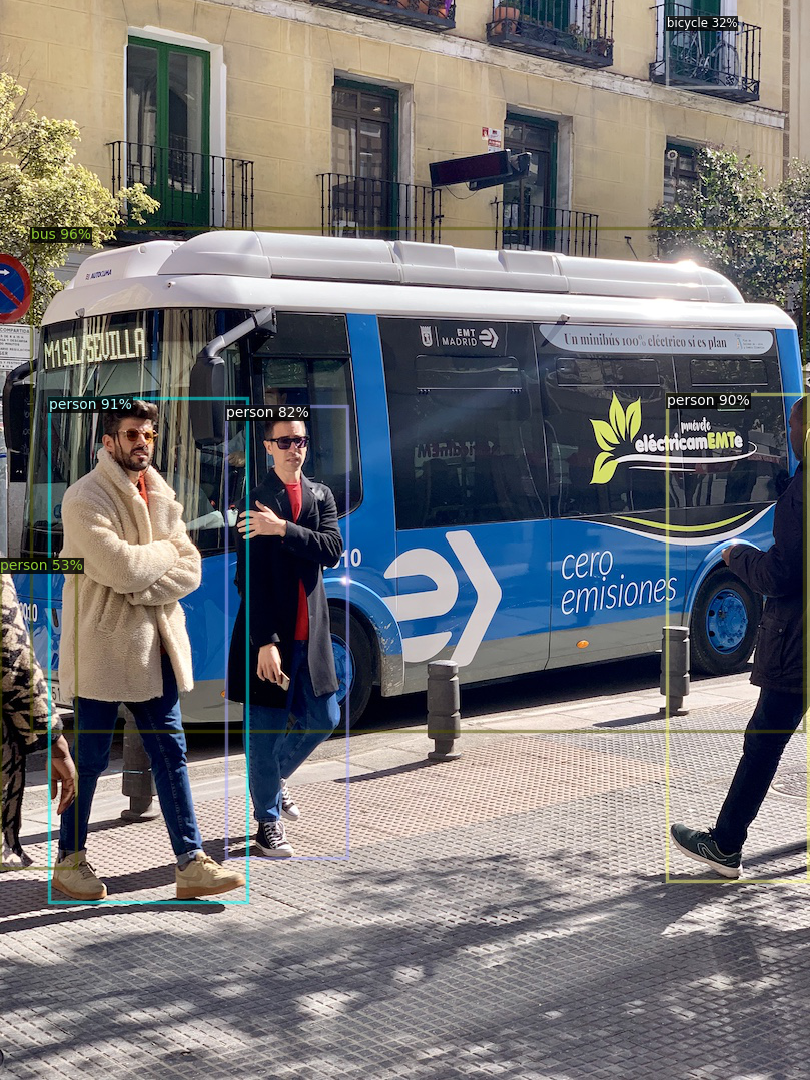

In [20]:
img = visualized_output.get_image()
Image.fromarray(img)